this script examines the difference between used data and updated data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import tqdm
import itertools
import numpy as np

In [2]:
pubs_path="../../data/NationalFunding/Data/DerivedData/CleanedRawData/pub.pkl"

In [3]:
pubs_df = pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[Canada, United States]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[France, Chile]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


### fractionalize the funded papers based on the number of funding institutions and distinguish by whether the paper is authored by the country or not

In [4]:
funded_df = pubs_df[pubs_df.funder_distinct!='Not-Funded']

#### fractionalize the funded publications by funders and distinguish the whether the funder is in the authorlist

In [5]:
frac_res = []
for row in tqdm.tqdm(funded_df[['dis','year','author','funder']].values):
    dis = row[0]
    year = row[1]
    authors = row[2]
    funders = row[3]
    n_funders = len(funders)
    for funder in funders:
        if funder in authors:
            frac_res.append([funder,year,dis,1/n_funders,'authored'])
        else:
            frac_res.append([funder,year,dis,1/n_funders,'not-authored'])

100%|█████████████████████████████| 7736940/7736940 [00:37<00:00, 205667.53it/s]


#### calculate the fraction of papers funded by country *C* when *C* is an author and not an auther

In [6]:
pub_funded_cntry = pd.DataFrame(frac_res, columns=['cntry','year','dis','frac_cnt','authored'])
pub_funded_cntry = pub_funded_cntry.groupby(['cntry','year','authored'])['frac_cnt'].sum().reset_index(name='funded_frac_cnt')
pub_funded_cntry = pub_funded_cntry.pivot(index=['cntry','year'],columns='authored',values='funded_frac_cnt')
pub_funded_cntry = pub_funded_cntry.rename(columns={'authored':'funded_authored_cnt','not-authored':'funded_not_authored_cnt'})
pub_funded_cntry.head()

authored          funded_authored_cnt  funded_not_authored_cnt
cntry       year                                              
Afghanistan 2010                  1.0                      NaN
            2011                  NaN                 0.333333
            2012                  NaN                 0.333333
            2015                  NaN                 0.427518
            2016                  NaN                 0.133929

#### Among all the funded publications, calculate the number of publications that are authored by the country

In [7]:
cntry_authored_cnt = funded_df[['id','year','author_distinct']
                   ].explode('author_distinct'
                            ).groupby(['author_distinct','year']).size().reset_index(name='authored_cnt')
cntry_authored_cnt = cntry_authored_cnt.rename(columns={'author_distinct':'cntry'})
cntry_authored_cnt.head(2)

,cntry,year,authored_cnt
0,Afghanistan,2009,7
1,Afghanistan,2010,13


#### calculate the numver of funded publication across all countries every year

In [8]:
funded_all_cnt = funded_df.groupby(['year']).size().reset_index(name='funded_global')
funded_all_cnt.head(2)

,year,funded_global
0,2009,497411
1,2010,592070


In [9]:
cntry_pub_cnt = cntry_authored_cnt.merge(funded_all_cnt,on='year',how='left')
cntry_pub_cnt['not_authored_cnt'] = cntry_pub_cnt['funded_global']-cntry_pub_cnt['authored_cnt']
cntry_pub_cnt.head(2)

,cntry,year,authored_cnt,funded_global,not_authored_cnt
0,Afghanistan,2009,7,497411,497404
1,Afghanistan,2010,13,592070,592057


#### calculate the funding ratio of authored publications and not authored publications and extract data for the United States and China

In [10]:
funding_ratio = pub_funded_cntry.reset_index().merge(cntry_pub_cnt, on=['cntry','year'])
funding_ratio['funded_authored_ratio'] = funding_ratio['funded_authored_cnt']/funding_ratio['authored_cnt']
funding_ratio['funded_not_authored_ratio'] = funding_ratio['funded_not_authored_cnt']/funding_ratio['not_authored_cnt']
us_chn_funding_ratio = funding_ratio[funding_ratio.cntry.isin(['China','United States'])]
us_chn_funding_ratio.replace(to_replace={'cntry':{'China':'china','United States':'usa'}},inplace=True)
us_chn_funding_ratio.set_index(['cntry','year'],inplace=True)
us_chn_funding_ratio.head()

/tmp/ipykernel_248392/2939555597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_chn_funding_ratio.replace(to_replace={'cntry':{'China':'china','United States':'usa'}},inplace=True)


funded_authored_cnt  funded_not_authored_cnt  authored_cnt   
cntry year                                                               
china 2009         76088.867188               883.309306         83947  \
      2010         91545.188739              1075.207306        101985   
      2011        112323.662495              1275.653791        124816   
      2012        135812.047642              1449.899266        149570   
      2013        163453.650956              1842.854991        178959   

            funded_global  not_authored_cnt  funded_authored_ratio   
cntry year                                                           
china 2009         497411            413464               0.906392  \
      2010         592070            490085               0.897634   
      2011         672839            548023               0.899914   
      2012         725358            575788               0.908017   
      2013         780975            602016               0.913358   

            funded_not_authored_ratio  
cntry year                             
china 2009                   0.002136  
      2010                   0.002194  
      2011                   0.002328  
      2012                   0.002518  
      2013                   0.003061

In [11]:
funded_adjust = pd.read_csv("../../data/NationalFunding/Data/RobustCheck/check_09_and_18/global_us_chn_stats_adjusted.csv")
funded_adjust = funded_adjust.set_index(['cntry','year'])
funded_adjust

total   funded  funded_estimated  estimated_lower   
cntry  year                                                        
china  2009   122394    88044      9.831465e+04     9.820844e+04  \
       2018   393720   337747      3.491807e+05     3.490420e+05   
global 2009  1038638   531320      6.135258e+05     6.126026e+05   
       2018  1548696  1051390      1.078351e+06     1.077757e+06   
usa    2009   280877   163769      1.946214e+05     1.943424e+05   
       2018   364237   257887      2.692382e+05     2.690262e+05   

             estimated_upper  
cntry  year                   
china  2009     9.842086e+04  
       2018     3.493195e+05  
global 2009     6.144491e+05  
       2018     1.078944e+06  
usa    2009     1.949004e+05  
       2018     2.694501e+05

#### for individual country, the fraction of papers that are funded by the country is estimated by $${F_{c,t} \over N_{c,t}}* \hat{P}_{c,t}+{Q_{c,t} \over N_{\neg c,t}}* \hat{P}_{\neg c,t}$$, where 

$F_{c}$: among all the funded papers that are authored by country c, the fraction of papers that are funded by country c in specific year t

$N_{c,t}$ number of funded papers that are authored by country c

$\hat{P}$ number of funded papers that are authored by c in the latest wos adjusted by the false negative rate

$Q_{c,t}$ among all the funded papers that are not authored by country c, the fraction of papers that are funded by country c in year t

$N_{\neg c,t}$ number of funded papers that are not authored by country c

$\hat{P}_{\neg c,t}$ number of funded papers that are not authored by country c in the latest wos



In [12]:
cntrys=['china','usa']
years=[2009,2018]
frac_estimated = []
for cntry, year in itertools.product(cntrys, years):
    authored_funded_ratio = us_chn_funding_ratio.loc[(cntry,year),'funded_authored_ratio']
    authored_funded_estimated = funded_adjust.loc[(cntry,year),'funded_estimated']
    
    total_funded_estimated = funded_adjust.loc[('global',year),'funded_estimated']
    
    funded_not_authored = total_funded_estimated-authored_funded_estimated
    funded_not_authored_ratio = us_chn_funding_ratio.loc[(cntry,year),'funded_not_authored_ratio']
    
    funded_estimated = (authored_funded_estimated*authored_funded_ratio)+(funded_not_authored*funded_not_authored_ratio)
    
    funded_ratio = funded_estimated/total_funded_estimated
    frac_estimated.append([cntry,year,funded_estimated, funded_ratio])
frac_estimated = pd.DataFrame(frac_estimated, columns=['cntry','year','funded_estimated','ratio_estimated'])  

In [13]:
frac_estimated

,cntry,year,funded_estimated,ratio_estimated
0,china,2009,90212.264634,0.147039
1,china,2018,326929.517673,0.303176
2,usa,2009,161985.233144,0.264024
3,usa,2018,187426.201289,0.173808


#### compare the estimated with the original data in our analysis

In [14]:
cntry_fund_path='../../data/NationalFunding/Data/DerivedData/Derived/cntry_fund_frac.csv'
cntry_frac_fund = pd.read_csv(cntry_fund_path)
cntry_frac_fund = cntry_frac_fund[cntry_frac_fund.funder!='Not-Funded']
cntry_frac_fund = cntry_frac_fund.groupby(['funder','year'])['cnt'].sum().reset_index()
cntry_frac_fund.head(2)

,funder,year,cnt
0,Afghanistan,2010,1.000000
1,Afghanistan,2011,0.333333


In [15]:
cntry_frac_fund = cntry_frac_fund.merge(funded_all_cnt, on='year')
cntry_frac_fund['ratio'] = cntry_frac_fund['cnt']/cntry_frac_fund['funded_global']
us_chn_frac_fund = cntry_frac_fund[cntry_frac_fund.funder.isin(['United States','China'])]
us_chn_frac_fund.head()

,funder,year,cnt,funded_global,ratio
31,China,2010,92620.396045,592070,0.156435
155,United States,2010,149823.559642,592070,0.253050
197,China,2011,113599.316286,672839,0.168836
323,United States,2011,163715.499662,672839,0.243320
365,China,2012,137261.946907,725358,0.189233


In [16]:
frac_estimated

,cntry,year,funded_estimated,ratio_estimated
0,china,2009,90212.264634,0.147039
1,china,2018,326929.517673,0.303176
2,usa,2009,161985.233144,0.264024
3,usa,2018,187426.201289,0.173808


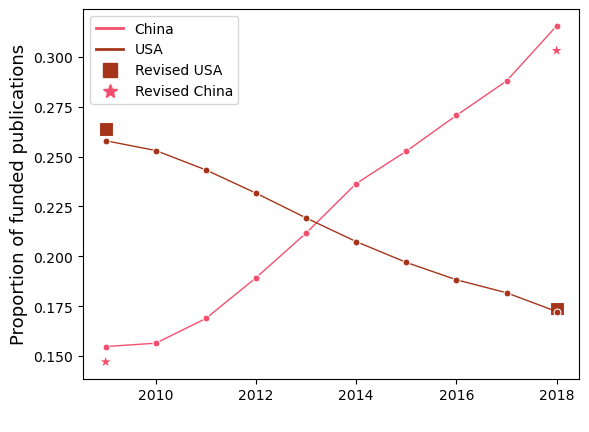

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x='year', y='ratio', hue='funder', data=us_chn_frac_fund, 
             palette={'United States':'#A6341B','China':'#F2506E'}, 
             marker='o',linewidth=1,markersize=5, legend=False,
             ax=ax)
sns.scatterplot(x='year',y='ratio_estimated',data=frac_estimated, hue = 'cntry', 
                palette={'usa':'#A6341B','china':'#F2506E'}, 
                style = 'cntry',markers={'usa':'s','china':'*'},s=100,legend=False,
                ax=ax)
ax.set_xlabel(" ")
ax.set_ylabel("Proportion of funded publications", fontsize=13)
legend = [Line2D([0], [0], color='#F2506E', lw=2, label='China'),
          Line2D([0], [0], color='#A6341B', lw=2, label='USA'),
          Line2D([0], [0], marker='s', color='#A6341B', linestyle='None', markersize=10, label='Revised USA'),
          Line2D([0], [0], marker='*', color='#F2506E', linestyle='None', markersize=10, label='Revised China')]

plt.legend(handles = legend)
plt.savefig("../../data/NationalFunding/Data/RobustCheck/check_09_and_18/frac_fund_us_chn_comparison",bbox_inches='tight')